In [1]:
# Data Management
import pandas as pd
import numpy as np

# Data Visualization
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style("whitegrid")

# Data splitting
from sklearn.model_selection import train_test_split

# Hyperparameter selection
from sklearn.model_selection import GridSearchCV

# Feature Selection
from sklearn.feature_selection import SelectKBest, chi2, RFE

# Modeling
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

from statsmodels.discrete.discrete_model import Logit
import statsmodels.tools as sm

# Model Evaluation
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, confusion_matrix, roc_auc_score, roc_curve
import itertools

# Data Cleaning

In [2]:
data = pd.read_csv('Surgery_Data.csv')

def data_cleaning(data):

    # converting into binary variables
    data[['Risk1Yr', 'PRE7', 'PRE8', 'PRE9', 'PRE10', 'PRE11', 'PRE17', 'PRE19', 'PRE25', 'PRE30', 'PRE32']] = \
    (data[[ 'Risk1Yr', 'PRE7', 'PRE8', 'PRE9', 'PRE10', 'PRE11', 'PRE17', 'PRE19', 'PRE25', 'PRE30', 'PRE32']] == 'T').astype(int)

    # converting into categorical variables
    #data['DGN'] = data.DGN.str[-1:].astype(int)
    #data['PRE6'] = data.replace(['PRZ0', 'PRZ1', 'PRZ2'], [1, 2, 3])
    data['PRE14'] = data.PRE14.str[-1:].astype(int)

    # renaming data variables
    col_names = {'Risk1Yr': 'Death_1yr', 'DGN': 'Diagnosis', 'PRE4': 'FVC', 'PRE5': 'FEV1', 'PRE6': 'Performance', 
                'PRE7': 'Pain', 'PRE8': 'Haemoptysis', 'PRE9': 'Dyspnoea', 'PRE10': 'Cough', 'PRE11': 'Weakness',
                'PRE14': 'Tumor_Size', 'PRE17': 'Diabetes_Mellitus', 'PRE19': 'MI_6mo', 'PRE25': 'PAD',
                'PRE30': 'Smoking', 'PRE32': 'Asthma', 'AGE': 'Age'}
    data = data.rename(index=str, columns=col_names)

    df = data[data.Age > 30]
    df = data[data.FEV1 < 8]

    print('The original data contains \033[1m' + str(len(data)) + '\033[0m observations, while after the applied changes there are \033[1m' + str(len(df)) + '\033[0m left.')
    
    return df

data = data_cleaning(data)

# Performance: replace values to be 1-3 (Good-Poor)
data = data.replace(['PRZ0', 'PRZ1', 'PRZ2'], [1, 2, 3])

data.head()

The original data contains 471 observations, while after the applied changes there are 456 left.


,Death_1yr,Diagnosis,FVC,FEV1,Performance,Pain,Haemoptysis,Dyspnoea,Cough,Weakness,Tumor_Size,Diabetes_Mellitus,MI_6mo,PAD,Smoking,Asthma,Age
0,0,DGN2,2.88,2.16,2,0,0,0,1,1,4,0,0,0,1,0,60
1,0,DGN3,3.40,1.88,1,0,0,0,0,0,2,0,0,0,1,0,51
2,0,DGN3,2.76,2.08,2,0,0,0,1,0,1,0,0,0,1,0,59
3,0,DGN3,3.68,3.04,1,0,0,0,0,0,1,0,0,0,0,0,54
4,1,DGN3,2.44,0.96,3,0,1,0,1,1,1,0,0,0,1,0,73


In [3]:
data.Diagnosis.value_counts()

DGN3    342
DGN2     49
DGN4     45
DGN5     13
DGN6      4
DGN8      2
DGN1      1
Name: Diagnosis, dtype: int64

In [4]:
# Diagnosis: get dummies and keep only significant ones
diag = pd.get_dummies(data.Diagnosis)

diag = diag.drop('DGN1', axis = 1)
#diag = diag.drop('DGN2', axis = 1)
#diag = diag.drop('DGN4', axis = 1)
diag = diag.drop('DGN5', axis = 1)
diag = diag.drop('DGN6', axis = 1)
diag = diag.drop('DGN8', axis = 1)
diag.head()

# Dropping department as we don't need it any more
data = data.drop('Diagnosis', axis=1)

# Joining the dummy vars of departments to our main data
data = data.join(diag)

data.head()

,Death_1yr,FVC,FEV1,Performance,Pain,Haemoptysis,Dyspnoea,Cough,Weakness,Tumor_Size,Diabetes_Mellitus,MI_6mo,PAD,Smoking,Asthma,Age,DGN2,DGN3,DGN4
0,0,2.88,2.16,2,0,0,0,1,1,4,0,0,0,1,0,60,1,0,0
1,0,3.40,1.88,1,0,0,0,0,0,2,0,0,0,1,0,51,0,1,0
2,0,2.76,2.08,2,0,0,0,1,0,1,0,0,0,1,0,59,0,1,0
3,0,3.68,3.04,1,0,0,0,0,0,1,0,0,0,0,0,54,0,1,0
4,1,2.44,0.96,3,0,1,0,1,1,1,0,0,0,1,0,73,0,1,0


# statsmodels for the whole data

In [5]:
# Building model for the whole data (no splitting here)
X = data.drop(['Death_1yr'], axis=1)
y = data.Death_1yr

model_stat = Logit.from_formula(formula='Death_1yr~'+'+'.join(X.columns),data=data)
results_stat = model_stat.fit()

results_stat.summary()

         Current function value: 0.373531
         Iterations: 35


C:\Users\Anna Danielyan\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              Death_1yr   No. Observations:                  456
Model:                          Logit   Df Residuals:                      437
Method:                           MLE   Df Model:                           18
Date:                Mon, 29 Apr 2019   Pseudo R-squ.:                  0.1211
Time:                        12:11:10   Log-Likelihood:                -170.33
converged:                      False   LL-Null:                       -193.79
                                        LLR p-value:                 0.0002171
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            -0.4155      1.634     -0.254      0.799      -3.618       2.787
FVC                   0.0641      0.354      0.181      0.856      -0.630       0.758
FEV1                 -0.3889      0.418     -0.931      0.352      -1.208       0.430
Performance          -0.2338      0.398     -0.588      0.557      -1.014       0.546
Pain                  0.8667      0.541      1.602      0.109      -0.193       1.927
Haemoptysis           0.2397      0.387      0.619      0.536      -0.519       0.999
Dyspnoea              1.1883      0.491      2.420      0.016       0.226       2.151
Cough                 0.5600      0.450      1.245      0.213      -0.322       1.442
Weakness              0.6180      0.380      1.625      0.104      -0.128       1.364
Tumor_Size            0.5331      0.186      2.864      0.004       0.168       0.898
Diabetes_Mellitus     0.8823      0.439      2.009      0.045       0.021       1.743
MI_6mo              -22.3600   1.11e+05     -0.000      1.000   -2.18e+05    2.18e+05
PAD                  -0.0412      0.980     -0.042      0.967      -1.962       1.880
Smoking               0.8499      0.469      1.813      0.070      -0.069       1.769
Asthma              -16.5832   9571.462     -0.002      0.999   -1.88e+04    1.87e+04
Age                  -0.0139      0.018     -0.791      0.429      -0.048       0.020
DGN2                 -1.5451      0.642     -2.406      0.016      -2.804      -0.286
DGN3                 -2.0245      0.544     -3.722      0.000      -3.091      -0.958
DGN4                 -1.6008      0.664     -2.412      0.016      -2.901      -0.300
=====================================================================================
"""

In [6]:
# Dropping almost all insignificant features and rerunning the same model as above
X = data.drop(['Death_1yr', 'MI_6mo', 'Asthma', 'FVC', 'PAD', 'Performance', 'Age', 'Cough', 'Haemoptysis', 'FEV1', 'Pain', 'Smoking'], axis=1)
y = data.Death_1yr

model_stat = Logit.from_formula(formula='Death_1yr~'+'+'.join(X.columns),data=data)
results_stat = model_stat.fit()

results_stat.summary()

Optimization terminated successfully.
         Current function value: 0.387261
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              Death_1yr   No. Observations:                  456
Model:                          Logit   Df Residuals:                      448
Method:                           MLE   Df Model:                            7
Date:                Mon, 29 Apr 2019   Pseudo R-squ.:                 0.08876
Time:                        12:11:10   Log-Likelihood:                -176.59
converged:                       True   LL-Null:                       -193.79
                                        LLR p-value:                 1.447e-05
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            -1.6403      0.566     -2.896      0.004      -2.750      -0.530
Dyspnoea              1.1500      0.470      2.446      0.014       0.229       2.071
Weakness              0.6402      0.329      1.948      0.051      -0.004       1.284
Tumor_Size            0.5852      0.181      3.241      0.001       0.231       0.939
Diabetes_Mellitus     0.9058      0.423      2.143      0.032       0.077       1.734
DGN2                 -1.2218      0.610     -2.004      0.045      -2.417      -0.027
DGN3                 -1.6683      0.504     -3.308      0.001      -2.657      -0.680
DGN4                 -1.3302      0.632     -2.103      0.035      -2.570      -0.091
=====================================================================================
"""

In [7]:
results_stat.get_margeff().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
        Logit Marginal Effects       
=====================================
Dep. Variable:              Death_1yr
Method:                          dydx
At:                           overall
=====================================================================================
                       dy/dx    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Dyspnoea              0.1345      0.054      2.475      0.013       0.028       0.241
Weakness              0.0749      0.038      1.958      0.050   -7.49e-05       0.150
Tumor_Size            0.0684      0.021      3.305      0.001       0.028       0.109
Diabetes_Mellitus     0.1059      0.049      2.164      0.030       0.010       0.202
DGN2                 -0.1429      0.071     -2.026      0.043      -0.281      -0.005
DGN3                 -0.1951      0.057     -3.400      0.001      -0.308      -0.083
DGN4                 -0.1556      0.073     -2.131      0.033      -0.299      -0.013
=====================================================================================
"""

In [8]:
# Getting probabilities for each observation of being 1
probab_stat = results_stat.predict(X)
probab_stat.head()

0    0.529689
1    0.105433
2    0.061604
3    0.061604
4    0.110741
dtype: float64

In [9]:
# Getting confusion matrix for the whole dataset
cnf_matrix_stat = results_stat.pred_table().T
cnf_matrix_stat

array([[382.,  64.],
       [  5.,   5.]])

In [10]:
print("Accuracy: \n", (cnf_matrix_stat[0,0]+cnf_matrix_stat[1,1])/len(data))
print("Sensitivity: \n",cnf_matrix_stat[1,1]/(cnf_matrix_stat[1,1]+cnf_matrix_stat[1,0]))
print("Specificity: \n",cnf_matrix_stat[0,0]/(cnf_matrix_stat[0,0]+cnf_matrix_stat[0,1]))

Accuracy: 
 0.8486842105263158
Sensitivity: 
 0.5
Specificity: 
 0.8565022421524664


# statsmodels for train_test_split

In [11]:
# Adding constant term to X
X_const = sm.add_constant(X)

# Splitting the data
x_train, x_test, y_train, y_test = train_test_split(X_const, y, test_size=.2, stratify=y, random_state=111)

model_stat_split = Logit(y_train, x_train)
results_stat_split = model_stat_split.fit()

results_stat_split.summary()

Optimization terminated successfully.
         Current function value: 0.401862
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              Death_1yr   No. Observations:                  364
Model:                          Logit   Df Residuals:                      356
Method:                           MLE   Df Model:                            7
Date:                Mon, 29 Apr 2019   Pseudo R-squ.:                 0.05358
Time:                        12:11:11   Log-Likelihood:                -146.28
converged:                       True   LL-Null:                       -154.56
                                        LLR p-value:                   0.02046
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -1.6443      0.664     -2.475      0.013      -2.946      -0.342
Dyspnoea              0.4746      0.602      0.788      0.431      -0.706       1.655
Weakness              0.2525      0.384      0.658      0.510      -0.499       1.004
Tumor_Size            0.4713      0.204      2.314      0.021       0.072       0.871
Diabetes_Mellitus     0.8831      0.462      1.910      0.056      -0.023       1.790
DGN2                 -0.7266      0.699     -1.039      0.299      -2.097       0.644
DGN3                 -1.3090      0.594     -2.203      0.028      -2.474      -0.144
DGN4                 -0.8335      0.703     -1.185      0.236      -2.212       0.545
=====================================================================================
"""

In [12]:
results_stat_split.get_margeff().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
        Logit Marginal Effects       
=====================================
Dep. Variable:              Death_1yr
Method:                          dydx
At:                           overall
=====================================================================================
                       dy/dx    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Dyspnoea              0.0577      0.073      0.789      0.430      -0.086       0.201
Weakness              0.0307      0.047      0.658      0.510      -0.061       0.122
Tumor_Size            0.0573      0.025      2.338      0.019       0.009       0.105
Diabetes_Mellitus     0.1074      0.056      1.926      0.054      -0.002       0.217
DGN2                 -0.0883      0.085     -1.042      0.297      -0.254       0.078
DGN3                 -0.1591      0.071     -2.230      0.026      -0.299      -0.019
DGN4                 -0.1013      0.085     -1.191      0.234      -0.268       0.065
=====================================================================================
"""

In [13]:
# Compareing predicted and actual values of y when threshold is 0.5
probab_stat_split = results_stat_split.predict(x_test)
predictions_stat_split = pd.DataFrame(probab_stat_split, columns=(['Probabilities']))
predictions_stat_split['y_pred'] = np.where(predictions_stat_split.Probabilities>=0.5, '1', '0')
predictions_stat_split['y_true'] = y_test

predictions_stat_split[10:20]

,Probabilities,y_pred,y_true
208,0.118101,0,0
423,0.118101,0,0
434,0.077138,0,0
396,0.118101,0,0
328,0.118101,0,0
350,0.118101,0,1
439,0.097140,0,0
168,0.168156,0,0
238,0.284864,0,1
360,0.118101,0,0


In [14]:
# Getting confusion matrix for the whole dataset
cnf_matrix_stat_split = pd.crosstab(predictions_stat_split.y_pred, predictions_stat_split.y_true)
cnf_matrix_stat_split

y_true,0,1
y_pred,,
0,78,13
1,0,1


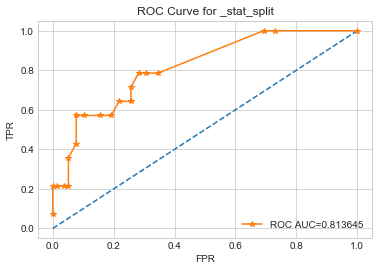

In [15]:
# Plotting ROC Curve for splited data
FPR,TPR,thresholds=roc_curve(y_test,predictions_stat_split.Probabilities)

plt.plot([0,1],[0,1], linestyle='--')
plt.plot(FPR, TPR, label='ROC AUC=%f'%roc_auc_score(y_test,predictions_stat_split.Probabilities), marker='*')

plt.legend(loc='lower right')

plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curve for _stat_split')

plt.show()

# sklearn for train_test_split

In [16]:
# Defining y and X
y = data.Death_1yr
X = data[['Dyspnoea', 'Weakness', 'Tumor_Size', 'Diabetes_Mellitus', 'DGN2', 'DGN3', 'DGN4']]

# Splitting data into train and test
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=.2, stratify=y, random_state=111)

# Defining model to be used
model_sk = LogisticRegression(class_weight='balanced', random_state=111)
model_sk.fit(x_train,y_train)

# predict, predict_proba
y_pred_sk = model_sk.predict(x_test)
probab_sk = model_sk.predict_proba(x_test)[:, 1]

# scores
acc = accuracy_score(y_test, y_pred_sk)
roc_auc = roc_auc_score(y_test, y_pred_sk)
recall = recall_score(y_test, y_pred_sk)
precision = precision_score(y_test, y_pred_sk)

scores = pd.DataFrame({'Accuracy': acc, 'ROC_AUC': roc_auc,
                       'Recall': recall, 'Precision': precision}, index=[model_sk])

scores.transpose()

,"LogisticRegression(C=1.0, class_weight='balanced', dual=False, fit_intercept=True, intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1, penalty='l2', random_state=111, solver='liblinear', tol=0.0001, verbose=0, warm_start=False)"
Accuracy,0.717391
ROC_AUC,0.716117
Recall,0.714286
Precision,0.312500



  Classification Report 
               precision    recall  f1-score   support

   Survived       0.93      0.72      0.81        78
       Died       0.31      0.71      0.43        14

avg / total       0.84      0.72      0.75        92



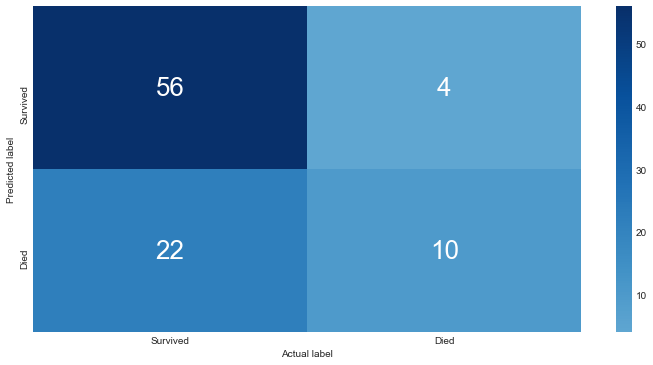

In [17]:
# Building confussion martix
classes = ['Survived', 'Died']

print('\n \033[1m Classification Report \n \033[0m', classification_report(y_test, y_pred_sk, target_names=classes))

cnf_matrix_sk = confusion_matrix(y_test, y_pred_sk).T
plt.figure(figsize=(10,5))
sns.heatmap(cnf_matrix_sk, cmap=plt.cm.Blues, center=0, annot=True, annot_kws={'size': 26}, xticklabels=classes, yticklabels=classes);


plt.tight_layout()
plt.xlabel('Actual label')
plt.ylabel('Predicted label')

plt.show()

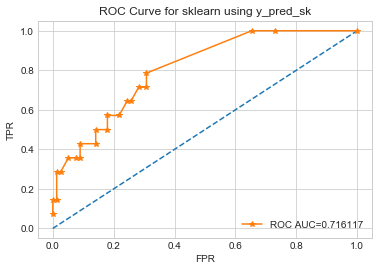

In [18]:
# Getting FPR and TPR
FPR,TPR,thresholds = roc_curve(y_test, probab_sk)

# Plotting ROC Curve
plt.plot([0,1],[0,1], linestyle='--')
plt.plot(FPR, TPR, label='ROC AUC=%f'%roc_auc_score(y_test,y_pred_sk), marker='*')

plt.legend(loc='lower right')

plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curve for sklearn using y_pred_sk')

plt.show()

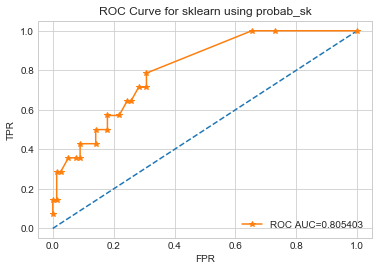

In [19]:
# Getting FPR and TPR
FPR,TPR,thresholds = roc_curve(y_test, probab_sk)

# Plotting ROC Curve
plt.plot([0,1],[0,1], linestyle='--')
plt.plot(FPR, TPR, label='ROC AUC=%f'%roc_auc_score(y_test,probab_sk), marker='*')

plt.legend(loc='lower right')

plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curve for sklearn using probab_sk')

plt.show()

# Lasso and ElasticNet

In [20]:
from sklearn.linear_model import LogisticRegression, Lasso, ElasticNet

In [21]:
model2 = Lasso()
model2.fit(x_train, y_train)

probab_lasso = model2.predict(x_test)

predictions_la = pd.DataFrame(probab_lasso, columns=(['Probabilities']))
predictions_la['y_pred'] = np.where(predictions_la.Probabilities>=0.5, '1', '0')
predictions_la['y_true'] = y_test

In [22]:
probab_lasso

array([0.1510989, 0.1510989, 0.1510989, 0.1510989, 0.1510989, 0.1510989,
       0.1510989, 0.1510989, 0.1510989, 0.1510989, 0.1510989, 0.1510989,
       0.1510989, 0.1510989, 0.1510989, 0.1510989, 0.1510989, 0.1510989,
       0.1510989, 0.1510989, 0.1510989, 0.1510989, 0.1510989, 0.1510989,
       0.1510989, 0.1510989, 0.1510989, 0.1510989, 0.1510989, 0.1510989,
       0.1510989, 0.1510989, 0.1510989, 0.1510989, 0.1510989, 0.1510989,
       0.1510989, 0.1510989, 0.1510989, 0.1510989, 0.1510989, 0.1510989,
       0.1510989, 0.1510989, 0.1510989, 0.1510989, 0.1510989, 0.1510989,
       0.1510989, 0.1510989, 0.1510989, 0.1510989, 0.1510989, 0.1510989,
       0.1510989, 0.1510989, 0.1510989, 0.1510989, 0.1510989, 0.1510989,
       0.1510989, 0.1510989, 0.1510989, 0.1510989, 0.1510989, 0.1510989,
       0.1510989, 0.1510989, 0.1510989, 0.1510989, 0.1510989, 0.1510989,
       0.1510989, 0.1510989, 0.1510989, 0.1510989, 0.1510989, 0.1510989,
       0.1510989, 0.1510989, 0.1510989, 0.1510989, 

In [23]:
cnf_la = pd.crosstab(predictions_la.y_pred, predictions_la.y_true)
cnf_la

""


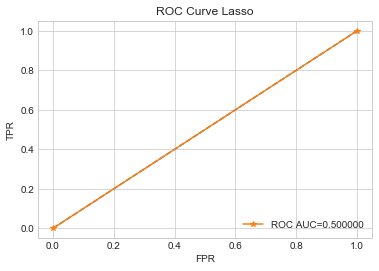

In [24]:
FPR,TPR,thresholds=roc_curve(y_test,predictions_la.Probabilities)

plt.plot([0,1],[0,1], linestyle='--')
plt.plot(FPR, TPR, label='ROC AUC=%f'%roc_auc_score(y_test,predictions_la.Probabilities), marker='*')

plt.legend(loc='lower right')

plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curve Lasso')

plt.show()

In [25]:
model3 = ElasticNet()
model3.fit(x_train, y_train)

probab_net = model3.predict(x_test)

predictions_en = pd.DataFrame(probab_net, columns=(['Probabilities']))
predictions_en['y_pred'] = np.where(predictions_en.Probabilities>=0.5, '1', '0')
predictions_en['y_true'] = y_test

In [26]:
probab_net

array([0.1510989, 0.1510989, 0.1510989, 0.1510989, 0.1510989, 0.1510989,
       0.1510989, 0.1510989, 0.1510989, 0.1510989, 0.1510989, 0.1510989,
       0.1510989, 0.1510989, 0.1510989, 0.1510989, 0.1510989, 0.1510989,
       0.1510989, 0.1510989, 0.1510989, 0.1510989, 0.1510989, 0.1510989,
       0.1510989, 0.1510989, 0.1510989, 0.1510989, 0.1510989, 0.1510989,
       0.1510989, 0.1510989, 0.1510989, 0.1510989, 0.1510989, 0.1510989,
       0.1510989, 0.1510989, 0.1510989, 0.1510989, 0.1510989, 0.1510989,
       0.1510989, 0.1510989, 0.1510989, 0.1510989, 0.1510989, 0.1510989,
       0.1510989, 0.1510989, 0.1510989, 0.1510989, 0.1510989, 0.1510989,
       0.1510989, 0.1510989, 0.1510989, 0.1510989, 0.1510989, 0.1510989,
       0.1510989, 0.1510989, 0.1510989, 0.1510989, 0.1510989, 0.1510989,
       0.1510989, 0.1510989, 0.1510989, 0.1510989, 0.1510989, 0.1510989,
       0.1510989, 0.1510989, 0.1510989, 0.1510989, 0.1510989, 0.1510989,
       0.1510989, 0.1510989, 0.1510989, 0.1510989, 

In [27]:
cnf_en = pd.crosstab(predictions_en.y_pred, predictions_en.y_true)
cnf_en

""


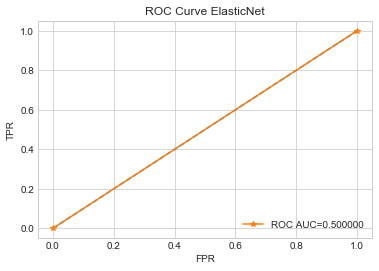

In [28]:
FPR,TPR,thresholds=roc_curve(y_test,predictions_en.Probabilities)

plt.plot([0,1],[0,1], linestyle='--')
plt.plot(FPR, TPR, label='ROC AUC=%f'%roc_auc_score(y_test,predictions_en.Probabilities), marker='*')

plt.legend(loc='lower right')

plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curve ElasticNet')

plt.show()